# Analyzing the European Parliament

In [1]:
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

import bokeh.models as bmo
import bokeh.plotting as bpl
from bokeh.palettes import d3

import prince

from tqdm.auto import tqdm

In [2]:
sns.set_context('talk')
bpl.output_notebook()

Loading BokehJS ...

## Download data

In [3]:
# %%bash

# wget --no-clobber https://parltrack.org/dumps/ep_votes.json.lz
# lzip -d ep_votes.json.lz

# wget --no-clobber https://parltrack.org/dumps/ep_meps.json.lz
# lzip -d ep_meps.json.lz

## Transform JSON to dataframes

### MEPs

In [4]:
fname = 'ep_meps.json'

tmp = []
with open(fname) as fd:
    for line in tqdm(fd.readlines()):
        line = line.lstrip('[,]')
        if len(line) == 0:
            continue

        data = json.loads(line)

        #         if not data['active']:
        #             continue

        tmp.append(
            {
                'UserID': data['UserID'],
                'name': data['Name']['full'],
                'birthday': data['Birth']['date'] if 'Birth' in data else np.nan,
                'active': data['active'],
                'group': data.get('Groups', [{'groupid': np.nan}])[-1][
                    'groupid'
                ],  # assumption: last group is latest one. Is this true?
            }
        )

  0%|          | 0/4150 [00:00<?, ?it/s]

In [5]:
df_meps = pd.DataFrame(tmp)
df_meps['birthday'] = pd.to_datetime(df_meps['birthday'])

df_meps.set_index('UserID', inplace=True)

df_meps['group'].replace(
    {'Group of the European United Left - Nordic Green Left': 'GUE/NGL'}, inplace=True
)  # is there a difference?

df_meps.head()

,name,birthday,active,group
UserID,,,,
2307,Hubert PIRKER,1948-10-03,False,PPE
111496,María Auxiliadora CORREA ZAMORA,1972-05-24,False,PPE
110987,Gino TREMATERRA,1940-09-03,False,PPE
1965,Jan MULDER,1943-10-03,False,ALDE
39321,Vicente Miguel GARCÉS RAMÓN,1946-11-10,False,S&D


### Votes

In [6]:
fname = 'ep_votes.json'

tmp = []
tmp_matrix = {}
with open(fname) as fd:
    for line in tqdm(fd.readlines()):
        line = line.lstrip('[,]')
        if len(line) == 0:
            continue

        data = json.loads(line)
        tmp.append(
            {'date': data['ts'], 'voteid': data['voteid'], 'title': data['title']}
        )

        if 'votes' in data:
            tmp_matrix[data['voteid']] = {
                **{
                    mep['mepid']: '+'
                    for mep_list in data['votes']
                    .get('+', {'groups': {'foo': []}})['groups']
                    .values()
                    for mep in mep_list
                    if 'mepid' in mep
                },
                **{
                    mep['mepid']: '-'
                    for mep_list in data['votes']
                    .get('-', {'groups': {'foo': []}})['groups']
                    .values()
                    for mep in mep_list
                    if 'mepid' in mep
                },
                **{
                    mep['mepid']: '0'
                    for mep_list in data['votes']
                    .get('0', {'groups': {'foo': []}})['groups']
                    .values()
                    for mep in mep_list
                    if 'mepid' in mep
                },
            }

  0%|          | 0/23906 [00:00<?, ?it/s]

In [7]:
df_votematrix = pd.DataFrame.from_dict(tmp_matrix, orient='index')

df_votematrix.index.name = 'voteid'
df_votematrix.columns.name = 'mepid'

# df_votematrix.sort_values('voteid', axis=0, inplace=True)
df_votematrix.sort_values('mepid', axis=1, inplace=True)

df_votematrix.head()

mepid,1,234,684,729,840,945,966,988,997,1002,...,204416,204418,204419,204420,204421,204443,204449,204733,205452,206158
voteid,,,,,,,,,,,,,,,,,,,,,
7754,NaN,NaN,+,+,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7818,-,+,-,-,NaN,-,NaN,NaN,+,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7759,+,+,+,+,NaN,+,+,NaN,+,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7755,NaN,0,+,NaN,NaN,+,0,NaN,+,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7760,-,-,-,-,NaN,-,+,NaN,+,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_votes = pd.DataFrame(tmp)
df_votes['date'] = pd.to_datetime(df_votes['date'])

df_votes.set_index('voteid', inplace=True)

df_votes.tail()

,date,title
voteid,,
116359,2020-07-23 12:49:32,B9-0229/2020 - Am 23
116398,2020-07-23 12:49:32,B9-0229/2020 - § 26/1
116399,2020-07-23 12:49:32,B9-0229/2020 - § 26/2
116360,2020-07-23 12:49:32,B9-0229/2020 - Am 1
116401,2020-07-23 16:52:06,B9-0229/2020 - Résolution


## Exploration

### MEP party distribution

In [9]:
df_meps['active'].sum()

705

(-1.1107175100739686,
 1.1005103586792213,
 -1.1057638158926402,
 1.1094386022707399)

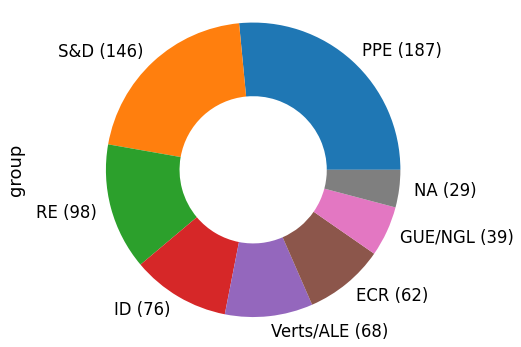

In [10]:
group_counts = df_meps.loc[df_meps['active'], 'group'].value_counts()
labels = group_counts.to_frame().apply(lambda x: f'{x.name} ({x.iloc[0]})', axis=1)

ax = group_counts.plot.pie(figsize=(8, 6), labels=labels, wedgeprops=dict(width=0.5))
ax.axis('equal')

### MEP age distribution

In [11]:
df_meps['age'] = (pd.Timestamp.today() - df_meps['birthday']) / np.timedelta64(1, 'Y')

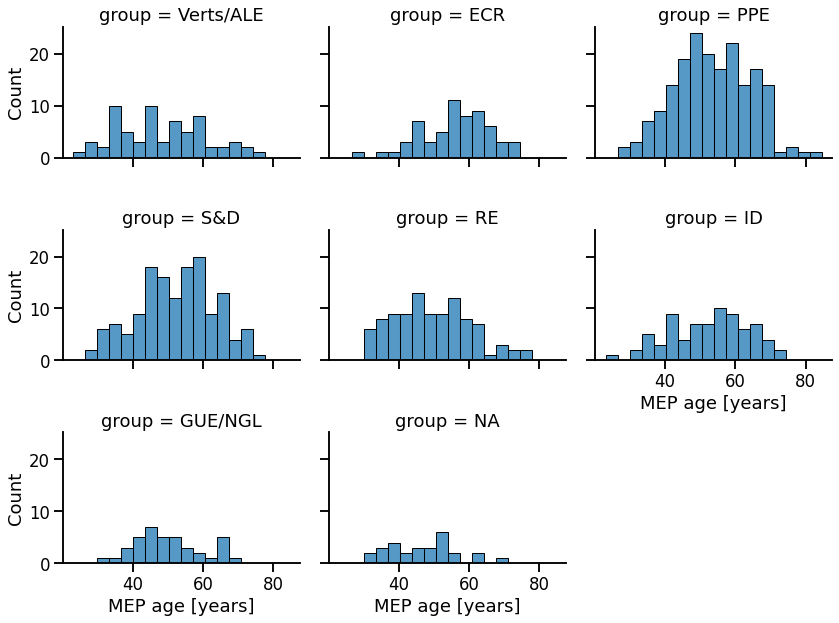

In [12]:
g = sns.displot(
    data=df_meps[df_meps['active']],
    x='age',
    col='group',
    col_wrap=3,
    height=3,
    aspect=4 / 3,
)

g.set_xlabels('MEP age [years]')

## Voting patterns

In [13]:
df_votematrix.head()

mepid,1,234,684,729,840,945,966,988,997,1002,...,204416,204418,204419,204420,204421,204443,204449,204733,205452,206158
voteid,,,,,,,,,,,,,,,,,,,,,
7754,NaN,NaN,+,+,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7818,-,+,-,-,NaN,-,NaN,NaN,+,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7759,+,+,+,+,NaN,+,+,NaN,+,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7755,NaN,0,+,NaN,NaN,+,0,NaN,+,+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7760,-,-,-,-,NaN,-,+,NaN,+,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Zoomed-out voting data overview

In [14]:
hm_sub = (
    df_votematrix.loc[
        df_votes[df_votes['date'] > '20200721'].index, df_meps[df_meps['active']].index
    ]
    .dropna(axis=1)
    .replace({'+': 1, '-': 0, '0': -1})
    .T.merge(df_meps[['group']], how='inner', left_index=True, right_index=True)
    .set_index('group', append=True)
    .reorder_levels(['group', 'UserID'])
    .sort_index()
)

In [15]:
hm_sub.head()

116365  116366  116368  116369  116370  116371  116326  116327  \
group UserID                                                                   
ECR   4465         1       1       1       1       1       1       1       1   
      4746         1       1       1       1       1       1       1       1   
      23712        1      -1      -1       0       0       0       0       0   
      23788        1       1       1       1       1      -1       0      -1   
      28297        1       1       1       1       1      -1       0      -1   

              116328  116329  ...  116355  116356  116357  116396  116358  \
group UserID                  ...                                           
ECR   4465         0       1  ...       1      -1       0      -1       0   
      4746         0       1  ...       1      -1       0      -1       0   
      23712        0       0  ...       0       1       0       0       0   
      23788        0       0  ...       0       0       1       1      -1   
      28297        0       0  ...       0       0       1       1      -1   

              116359  116398  116399  116360  116401  
group UserID                                          
ECR   4465         1       1       1       0      -1  
      4746         1       1       1       0      -1  
      23712       -1       1      -1       0       0  
      23788       -1       1       1       0       0  
      28297       -1       1       1       0       0  

[5 rows x 62 columns]

In [16]:
hm_sub_grpd = hm_sub.groupby('group').agg(lambda x: x.value_counts().index[0])
hm_sub_grpd.head()

,116365,116366,116368,116369,116370,116371,116326,116327,116328,116329,...,116355,116356,116357,116396,116358,116359,116398,116399,116360,116401
group,,,,,,,,,,,,,,,,,,,,,
ECR,1,1,1,1,1,-1,0,-1,0,0,...,0,0,0,1,0,-1,1,1,0,0
GUE/NGL,1,1,1,0,1,1,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1
ID,1,1,0,0,1,1,0,0,1,1,...,1,1,1,1,-1,1,1,1,1,0
NA,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,1,1,1,-1,1
PPE,1,1,1,1,1,1,0,0,0,0,...,0,0,0,1,0,0,1,1,0,1


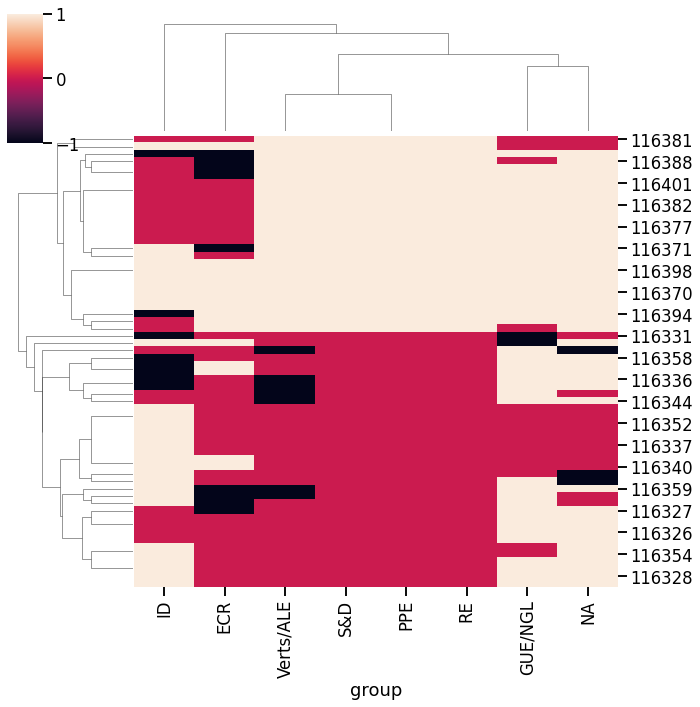

In [17]:
sns.clustermap(hm_sub_grpd.T)

### Who is the most active MEP?

Here we equate "active" with "has voted most often". This is most likely quite misleading.

In [18]:
df_hasvoted = ~df_votematrix[df_meps[df_meps['active']].index].isna()

In [19]:
df_hasvoted.sum(axis=0).sort_values(ascending=False).to_frame('vote_count').merge(
    df_meps, how='left', left_index=True, right_index=True
).head(10)

,vote_count,name,birthday,active,group,age
mepid,,,,,,
28266,22954,Sophia in 't VELD,1963-09-13,True,RE,57.595680
1913,22703,Evelyne GEBHARDT,1954-01-19,True,S&D,67.244064
2323,22394,Rainer WIELAND,1957-02-19,True,PPE,64.158443
4246,22324,Othmar KARAS,1957-12-24,True,PPE,63.315168
28219,22324,Daniel CASPARY,1976-04-04,True,PPE,45.036900
2341,22269,Michael GAHLER,1960-04-22,True,PPE,60.987947
28224,22164,Markus PIEPER,1963-05-15,True,PPE,57.926967
28298,21992,Iratxe GARCÍA PÉREZ,1974-10-07,True,S&D,46.529060
23821,21912,József SZÁJER,1961-09-07,True,PPE,59.610779


### Cluster MEPs by votes

#### Prepare data

In [20]:
df_subset = df_votematrix[df_meps[df_meps['active']].index].tail(1000)
df_subset.head()

mepid,96750,4746,23788,96810,96808,4560,38595,1992,125106,4391,...,204413,204334,204331,204346,204449,204400,197780,204733,205452,206158
voteid,,,,,,,,,,,,,,,,,,,,,
115197,+,+,+,+,+,+,+,+,+,+,...,+,-,+,+,+,+,+,+,+,NaN
115198,+,-,-,-,+,+,+,+,-,+,...,+,-,+,-,+,+,+,+,+,NaN
115055,+,-,-,-,+,+,+,+,-,+,...,+,+,-,-,+,-,-,+,+,NaN
115200,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,+,+,NaN
115201,+,-,-,-,-,-,+,-,-,-,...,+,-,-,-,-,-,-,+,-,NaN


#### Apply Multiple Correspondence Analysis (MCA)

In [21]:
mca = prince.MCA(n_components=2)
df_mca = mca.fit_transform(df_subset.T)

df_mca.columns = ('MCA0', 'MCA1')
df_mca.index.rename('mepid', inplace=True)
df_mca['group'] = df_meps.loc[df_meps['active'], 'group']

print(df_mca.shape)
df_mca.head()

(705, 3)


,MCA0,MCA1,group
mepid,,,
96750,-0.378434,0.620655,Verts/ALE
4746,0.741391,-0.488453,ECR
23788,0.504421,-0.913227,ECR
96810,0.743789,-0.495060,ECR
96808,-0.281795,-0.354040,PPE


#### Static visualization

In [22]:
party_ideology = {
    'Verts/ALE': 'green',
    'ECR': 'conservative',
    'PPE': 'liberal\nconservative',
    'S&D': 'socialist',
    'RE': 'liberal',
    'ID': 'right-wing',
    'GUE/NGL': 'left-wing',
}

Text(0.5, 1.0, 'MEP Clustering based on Voting Patterns')

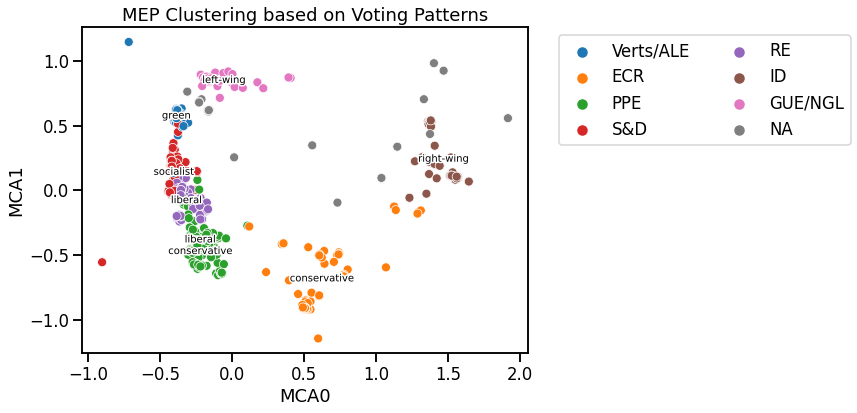

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(data=df_mca, x='MCA0', y='MCA1', hue='group', ax=ax)

for party, row in df_mca.groupby('group').mean().iterrows():
    if party == 'NA':
        continue
    ax.text(
        row.MCA0,
        row.MCA1,
        party_ideology.get(party),
        ha='center',
        va='center',
        fontsize=10,
        path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")],
    )

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), ncol=2, title=None)
ax.set_title('MEP Clustering based on Voting Patterns')

#### Interactive visualization

In [24]:
# generate data for each tooltip
hover_data = df_meps.loc[df_mca.index]

hover_data['name'] = hover_data['name'].str.title()
hover_data['birthday'] = hover_data['birthday'].apply(
    lambda x: x.strftime("%Y-%m-%d") if not pd.isnull(x) else 'undef'
)
hover_data['age'] = hover_data['age'].apply(
    lambda x: int(x) if not pd.isnull(x) else -1
)

df_data = df_mca.merge(
    hover_data.drop('group', axis=1), left_index=True, right_index=True
)
df_data.head()

,MCA0,MCA1,group,name,birthday,active,age
mepid,,,,,,,
96750,-0.378434,0.620655,Verts/ALE,François Alfonsi,1953-09-14,True,67
4746,0.741391,-0.488453,ECR,Sergio Berlato,1959-07-27,True,61
23788,0.504421,-0.913227,ECR,Adam Bielan,1974-09-12,True,46
96810,0.743789,-0.495060,ECR,Carlo Fidanza,1976-09-21,True,44
96808,-0.281795,-0.354040,PPE,Pablo Arias Echeverría,1970-06-30,True,50


In [25]:
# set up point colors
palette = d3['Category10'][df_data['group'].nunique()]
color_map = bmo.CategoricalColorMapper(
    factors=df_data['group'].unique(), palette=palette
)

In [26]:
# create figure
p = bpl.figure(
    tools='hover,pan,reset,wheel_zoom,box_zoom',
    active_scroll='wheel_zoom',
    tooltips=[(col, f'@{col}') for col in hover_data],
    background_fill_color='black',
)

p.scatter(
    x='MCA0',
    y='MCA1',
    color={'field': 'group', 'transform': color_map},
    legend_field='group',
    size=5,
    source=df_data,
)

p.grid.visible = False
p.axis.visible = False

bpl.show(p)